In [3]:
import pandas as pd
import numpy as np
data=pd.read_csv('bank-full.csv')
print(f"数据形状：{data.shape}")
print("-------------------------")
print(f"列名: {data.columns.tolist()}")
print("-------------------------")
print(data.dtypes)
print("-------------------------")
# 查看数据整体信息 (非空值数量、数据类型等)
data.info()
print("-------------------------")
# 查看前几行数据
print(data.head())

数据形状：(45211, 17)
-------------------------
列名: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
-------------------------
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object
-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  obj

In [4]:
print(data.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [5]:

#编码处理
data["y"]=data["y"].map({"yes":1,"no":0})
data["default"]=data["default"].map({"yes":1,"no":0})
data["loan"]=data["loan"].map({"yes":1,"no":0})
data["housing"]=data["housing"].map({"yes":1,"no":0})
data["marital"]=data["marital"].map({"married":1,"single":0,"divorced":2})
data = pd.concat([data, pd.get_dummies(data["education"], prefix="edu")], axis=1)
data = pd.concat([data, pd.get_dummies(data["job"], prefix="job")], axis=1)#对于特征列较多，可以使用独热编码
data = pd.concat([data, pd.get_dummies(data["contact"], prefix="contact")], axis=1)
data = pd.concat([data, pd.get_dummies(data["month"], prefix="month")], axis=1)
data= pd.concat([data, pd.get_dummies(data["poutcome"], prefix="poutcome")], axis=1)
data.drop(columns=["education","job","contact","month","poutcome"],inplace=True )#删除原始的类别列，只保留编码后的列



In [6]:
#k折交叉验证
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold

# 1. 拆分特征和目标
X = data.drop(columns=["y"])  # 特征
y = data["y"]

# 2. 手动指定数值列
numeric_features = ["balance", "duration","age","day"]

# 3. 构造 ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),  # 归一化数值列
        ("cat", "passthrough", [col for col in X.columns if col not in numeric_features])  # 保留其他列
    ]
)

# 4. Pipeline（预处理 + 模型）
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

# 5. K 折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=kf, scoring="accuracy")

print("每折得分:", scores)
print("平均得分:", scores.mean())


每折得分: [0.89959084 0.90157045 0.89836319 0.90422473 0.90356116]
平均得分: 0.901462074964748


In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (Linear Kernel)": SVC(kernel="linear", probability=True)
}

scoring = ["accuracy", "f1"]  # 只计算两个指标
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", model)
    ])
    scores = cross_validate(pipeline, X, y, cv=kf, scoring=scoring, n_jobs=-1)
    results[name] = {metric: scores[f"test_{metric}"].mean() for metric in scoring}

import pandas as pd
df_results = pd.DataFrame(results).T
print(df_results)


                     accuracy        f1
Logistic Regression  0.901440  0.449246
SVM (Linear Kernel)  0.892814  0.290989



Logistic Regression Metrics:
Accuracy: 0.8995, Precision: 0.6564, Recall: 0.3501, F1: 0.4567, ROC-AUC: 0.9045


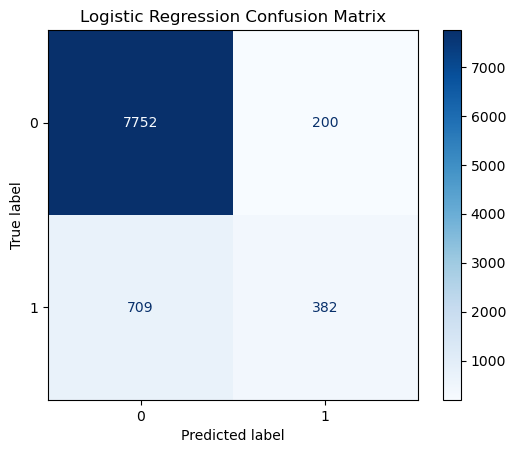

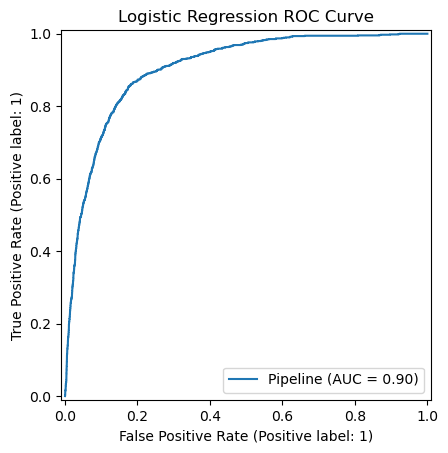


SVM (Linear Kernel) Metrics:
Accuracy: 0.8906, Precision: 0.6678, Recall: 0.1861, F1: 0.2910, ROC-AUC: 0.9027


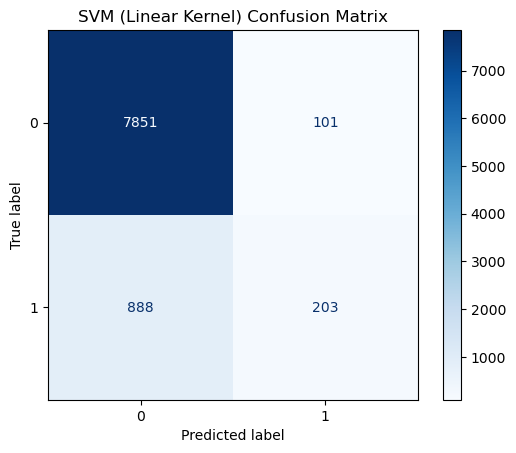

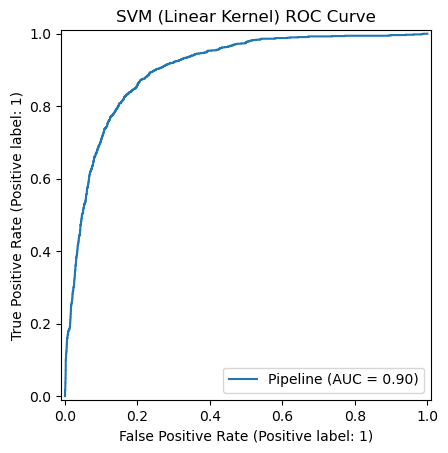

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ 创建测试集
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# 2️⃣ 遍历模型计算指标并绘图
# -------------------------------
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", model)
    ])
    
    # 训练
    pipeline.fit(X_train, y_train)
    
    # 预测
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:,1]  # ROC-AUC用
    
    # 计算指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    print(f"\n{name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    
    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    
    # ROC 曲线
    roc_disp = RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
    plt.title(f"{name} ROC Curve")
    plt.show()
